# Import Libraries

In [55]:
#import relevant packages
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
%matplotlib inline
from google.colab import files
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import chi2_contingency
from tabulate import tabulate
from scipy.stats import yeojohnson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML
from google.colab import drive

#Prepare The Notbook

In [56]:
# Function to create scrollable table within a small window
def create_scrollable_table(data, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += data.to_html()
    html += '</div>'
    return html

    # Header
    table_html += '<thead><tr>'
    table_html += ''.join(f'<th>{col}</th>' for col in data.columns)
    table_html += '</tr></thead><tbody>'

    # Rows
    for _, row in data.iterrows():
        table_html += '<tr>'
        table_html += ''.join(f'<td>{value}</td>' for value in row)
        table_html += '</tr>'

    table_html += '</tbody></table></div>'
    return table_html

# Import Data

In [57]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
data = pd.read_csv('///content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [59]:
head = data.head()

# create_scrollable_table is defined somewhere in your code
html_head = create_scrollable_table(head, 'head', 'Head of the dataset')

# Display the HTML table to show all features
display(HTML(html_head))

In [60]:
data = data.drop('customerID', axis=1)

#

# Discovring The Data

In [61]:
data.shape

(7043, 20)

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


we note that TotalCharges it's object but it's type is numeric so we will transform it

In [63]:
#transform the type of TotalCharges from object to numrical
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')


## Searching About Missing Values

In [64]:
# Null values in the dataset
null_values = data.isnull().sum()
html_null_values = null_values.to_frame().to_html()

# Show missing values
show_missing_values = data[data.isna().any(axis=1)]
html_show_missing_values = show_missing_values.to_html()

# Display HTML tables
display(HTML("<h2>Null Values in the Dataset</h2>" + html_null_values))
display(HTML("<h2>Show Missing Values of Each Feature</h2>" + html_show_missing_values))


there 11 missing(nan) in TotalCharges

In [65]:
# handling the missing values with  median
num_missing_values = data['TotalCharges'].isnull().sum()
print(f"missing values in 'TotalCharges befor handling missing': {num_missing_values}")

data.dropna(subset=['TotalCharges'], inplace=True)


num_missing_values = data['TotalCharges'].isnull().sum()
print(f" missing values in 'TotalCharges after handling missing ': {num_missing_values}")

missing values in 'TotalCharges befor handling missing': 11
 missing values in 'TotalCharges after handling missing ': 0


## Searching About Duplicates

In [66]:
data.duplicated().sum()

22

there aren 22 duplicated so i will reemove them

In [67]:
data.drop_duplicates(inplace=True)

# EDA and Preprocessing For The Target Variable

## Discovering The Target

In [68]:
# discribe the target
target_summary_stats = data['Churn'].describe().to_frame().T
print(target_summary_stats)
print('-----------------------------')
# the unique values of target variable
print("Unique Values Of Churn : ", data['Churn'].unique())
print('-----------------------------')
#check from balance
churn_value_counts = data['Churn'].value_counts()
print('The Count Of Each Class : ','\n' ,churn_value_counts)


      count unique top  freq
Churn  7010      2  No  5153
-----------------------------
Unique Values Of Churn :  ['No' 'Yes']
-----------------------------
The Count Of Each Class :  
 No     5153
Yes    1857
Name: Churn, dtype: int64


from the result we note that the target is unbalanced , we have 2 classes(yes,no) ,and  'no' is the most common class

## Target Encoding

In [69]:

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the 'Churn' column
data['Churn'] = label_encoder.fit_transform(data['Churn'])

# Print the unique values after label encoding
print("Churn ", data['Churn'].unique())

Churn  [0 1]


# EDA and Preprocessing For Numerical Features

In [70]:
#select the numrical features only and drop target
numerical_features = data.select_dtypes(include=['int64', 'float64']).drop(['Churn'], axis=1)


## Ensure from the data types

In [71]:
head_numrical=numerical_features.head()

html_head_numrical = create_scrollable_table(head_numrical, 'head_numrical', 'Head of the numrical features')

# Display the HTML
display(HTML(html_head_numrical))

In [72]:
#the unique values of each numrical feature

def display_unique_values(dataframe):
    unique_values_html = ""
    for column in dataframe.columns:
        unique_values = dataframe[column].unique()
        unique_values_html += f"<h4>Unique values for {column}:</h4>"
        unique_values_html += "<div style='max-height: 200px; overflow-y: auto;'>"
        unique_values_html += "<ul>"
        for value in unique_values:
            unique_values_html += f"<li>{value}</li>"
        unique_values_html += "</ul>"
        unique_values_html += "</div>"

    display(HTML(unique_values_html))

# Call the function to display unique values
display_unique_values(numerical_features)

we  note that SeniorCitizen is a categorical feature not a numerical

In [73]:
#drop SeniorCitizen from the numrical features
numerical_features.drop(['SeniorCitizen'], axis=1, inplace=True)

In [74]:
# Convert the 'SeniorCitizen' column to object type
data['SeniorCitizen'] = data['SeniorCitizen'].astype(object)

In [75]:
# Summary statistics for numerical features


# Calculate summary statistics
summary_stats = numerical_features.describe().T

# Create an HTML table
html_numerical = create_scrollable_table(summary_stats, 'numerical_features', 'Summary statistics for numerical features')

# Display the HTML
display(HTML(html_numerical))

## ANOVA_Test

In [76]:
x


# Assuming df is your DataFrame with numeric features and target variable
# Replace 'Churn' with the actual name of your target column
target_column = 'Churn'
significance_level = 0.05

# Extract numeric features from the DataFrame
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
data.fillna(numerical_features.median(), inplace=True)
# Create a list to store results
results = []

# Perform ANOVA test for each numeric feature
for column in numeric_features:
    if column != target_column:
        # Perform ANOVA test
        _, p = f_oneway(*[data[data[target_column] == group][column] for group in data[target_column].unique()])

        significance = "Significant" if p < significance_level else "Not Significant"

        results.append([column, p, significance])

# Create a DataFrame from the results
result_df = pd.DataFrame(results, columns=["Feature", "P-value", "Significance"])

# Print the tabulated results
print('ANOVA Test Between The Target Variable (Churn) And the Numeric Features:')
print(tabulate(result_df, headers='keys', tablefmt='pretty', showindex=False))



ANOVA Test Between The Target Variable (Churn) And the Numeric Features:
+----------------+------------------------+--------------+
|    Feature     |        P-value         | Significance |
+----------------+------------------------+--------------+
|     tenure     | 3.093127427396592e-205 | Significant  |
| MonthlyCharges | 2.0218234870891158e-60 | Significant  |
|  TotalCharges  | 3.914665283676891e-63  | Significant  |
+----------------+------------------------+--------------+


All features are significant

## Searching About Outliers

<Figure size 1600x800 with 0 Axes>

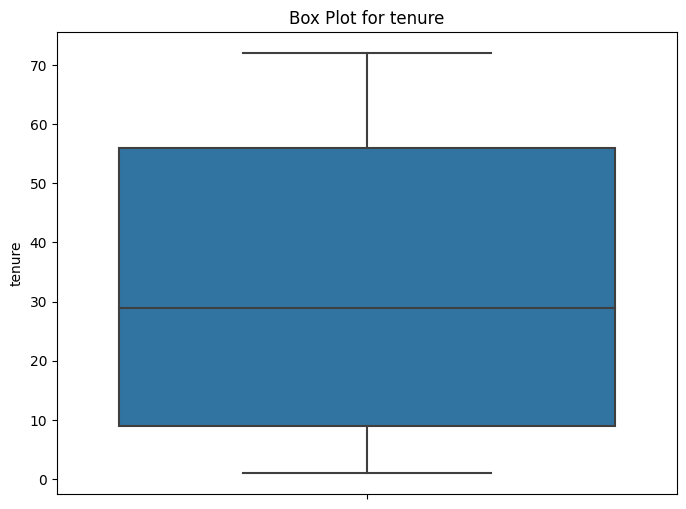

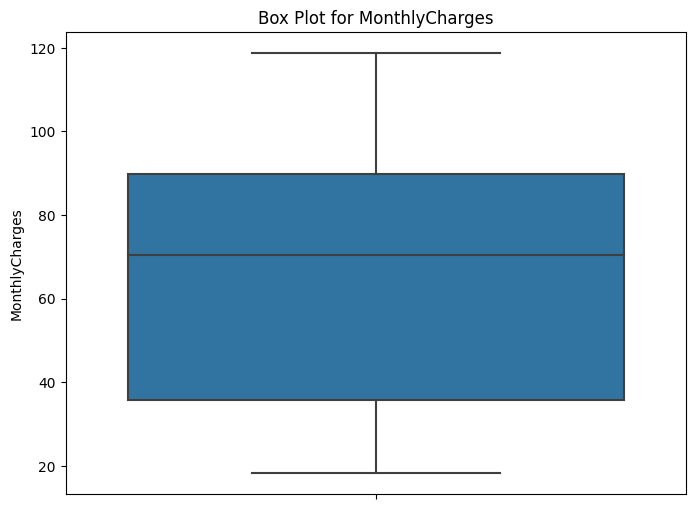

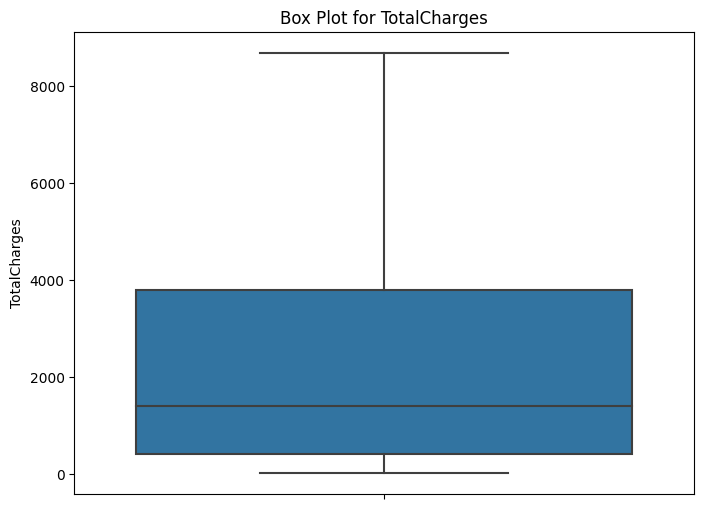

In [77]:


# Assuming numerical_features is your DataFrame with numerical features
# If you haven't selected numerical features yet, use the previous code to obtain numerical_features

# Set the size of the figure
plt.figure(figsize=(16, 8))

# Iterate through each numerical feature and create a box plot
for column in numerical_features.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=numerical_features[column])  # Use 'y' instead of 'x'
    plt.title(f'Box Plot for {column}')
    plt.show()

there aren't outliers

## Check for multicollinearity

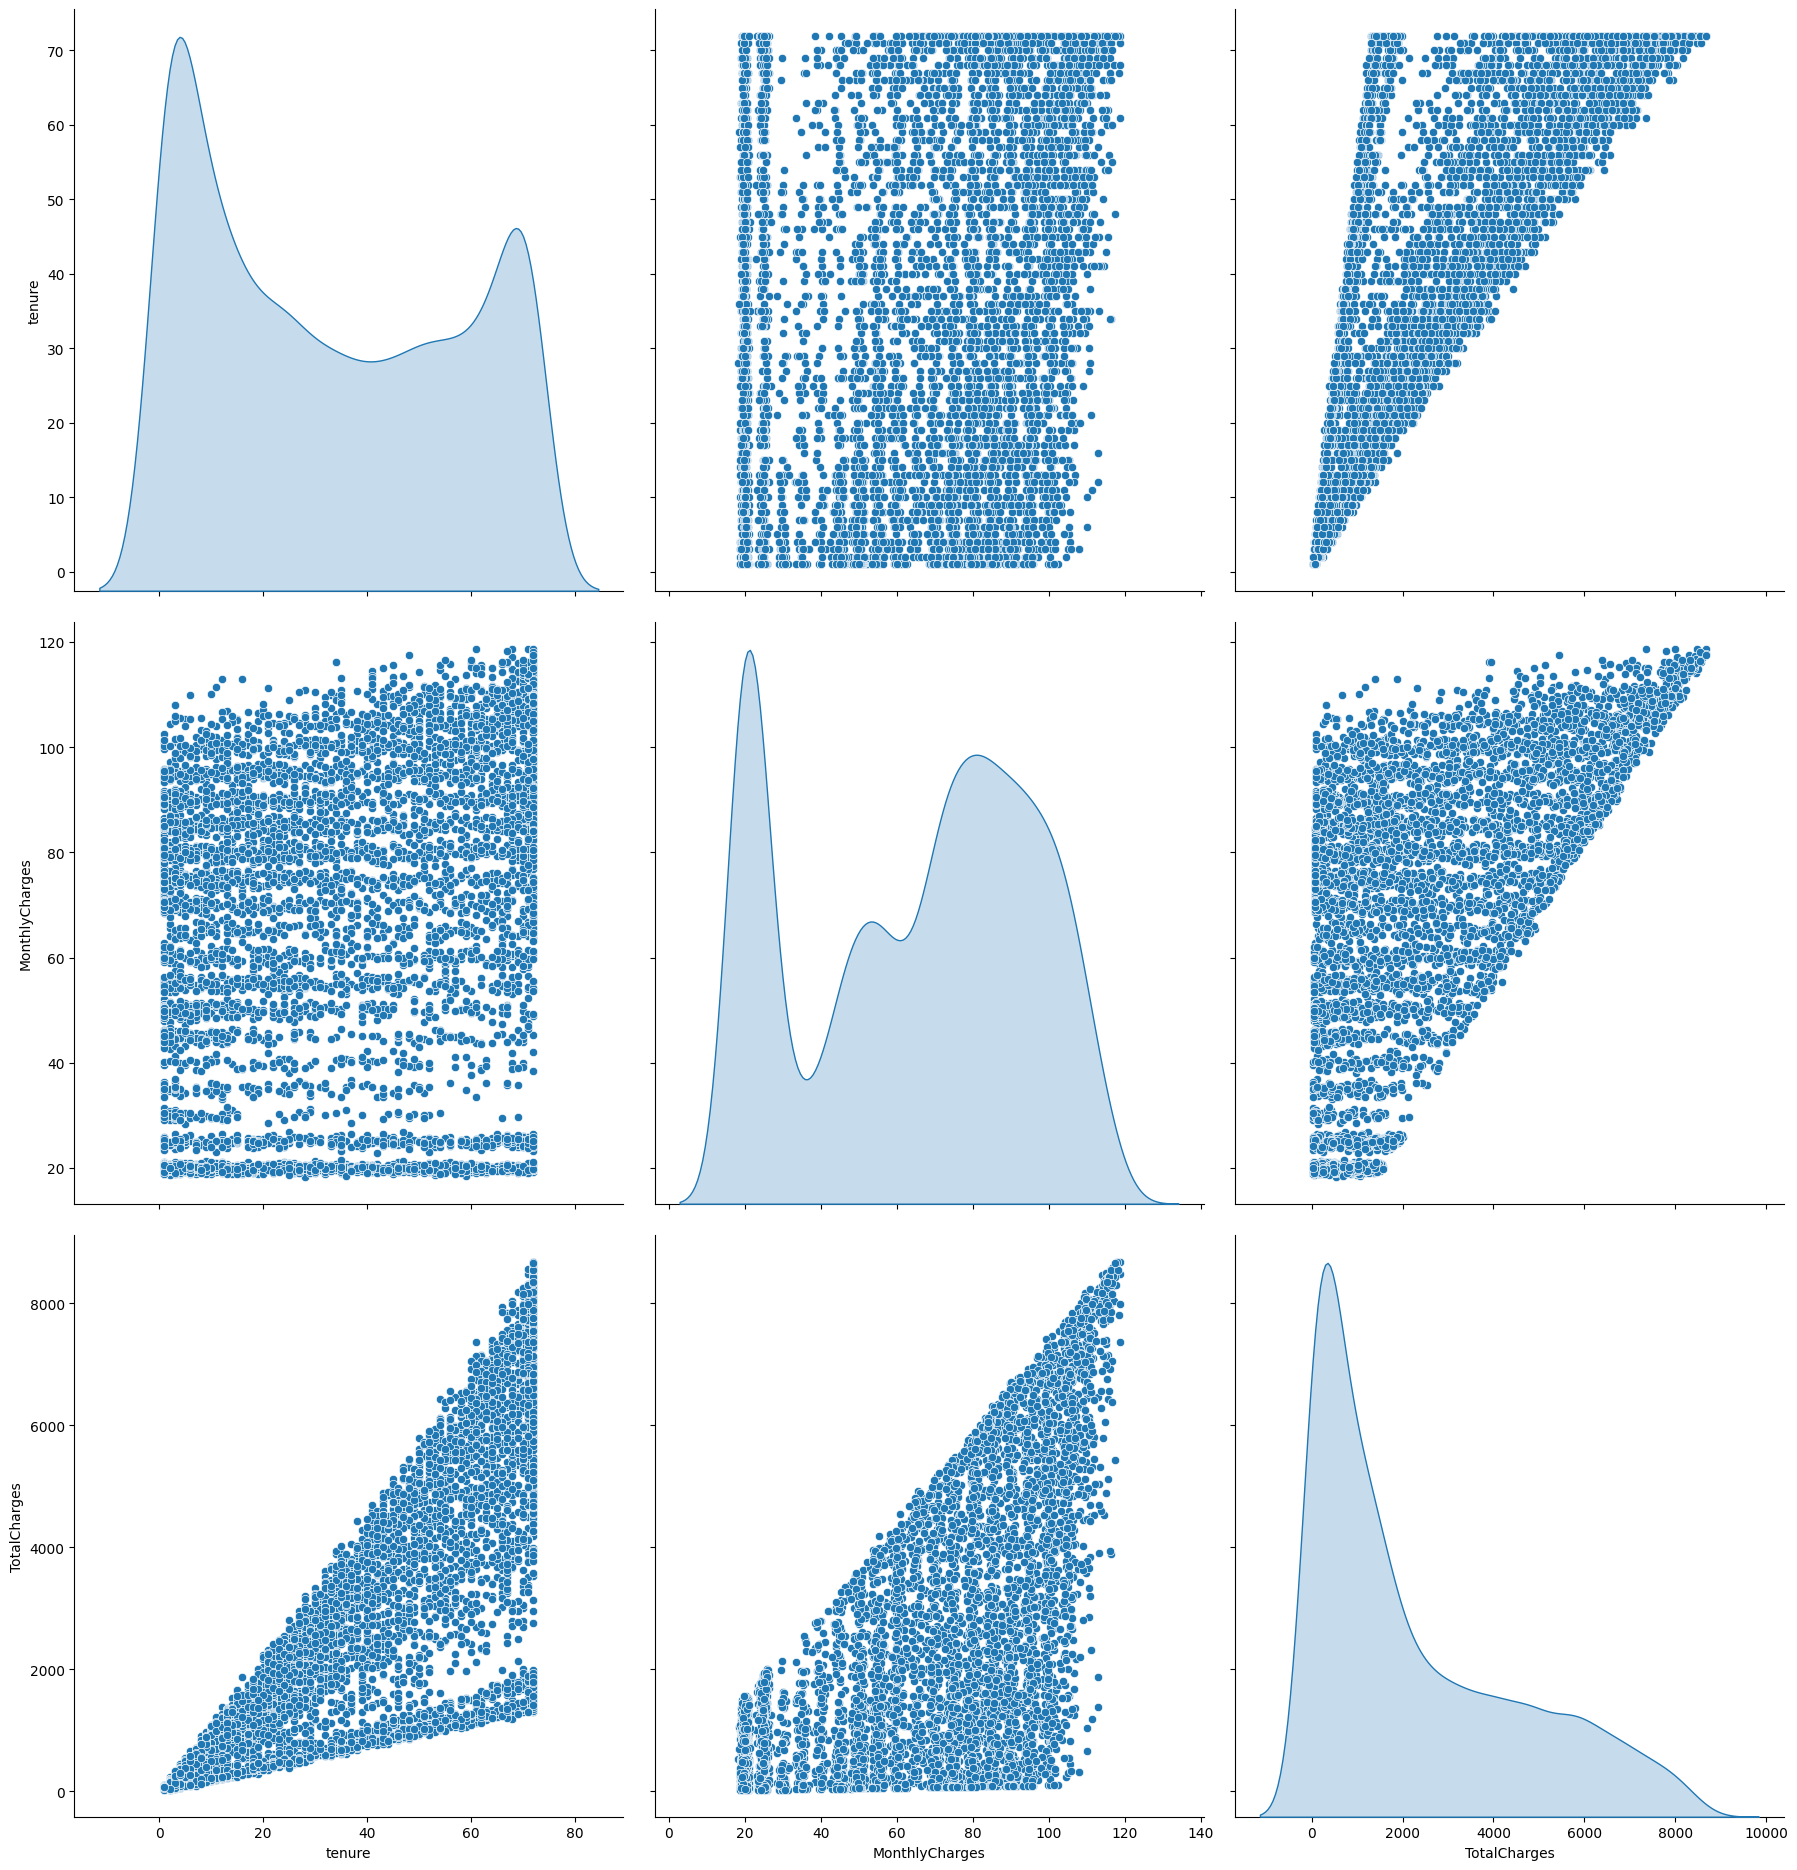

In [78]:



#Check for multicollinearity using Scatter Matrix
scatter_matrix = sns.pairplot(numerical_features, diag_kind='kde', plot_kws={'alpha': 1})
scatter_matrix.fig.set_size_inches(20, 20)
plt.show()

In [79]:

#handling the missing values in numric_fetures with mean
numerical_features.fillna(numerical_features.median(), inplace=True)
# Compute the VIF for each independent variable
vif = pd.DataFrame()
vif["variable"] = numerical_features.columns
vif["VIF"] = [variance_inflation_factor(numerical_features.values, i) for i in range(numerical_features.shape[1])]
# Select variables with high VIF
high_vif_variables = vif[vif["VIF"] > 10]["variable"]
print(high_vif_variables)

Series([], Name: variable, dtype: object)


there aren't multicollinearity

## Features Distributions

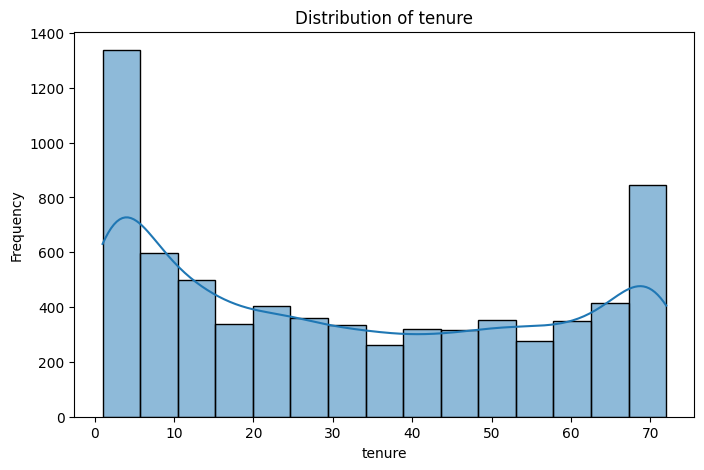

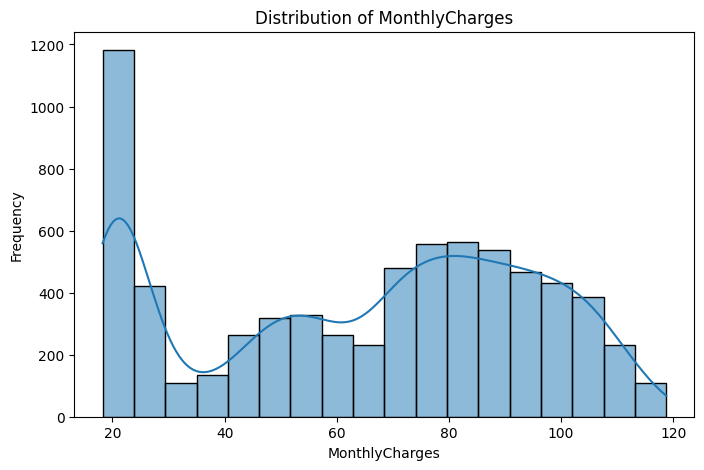

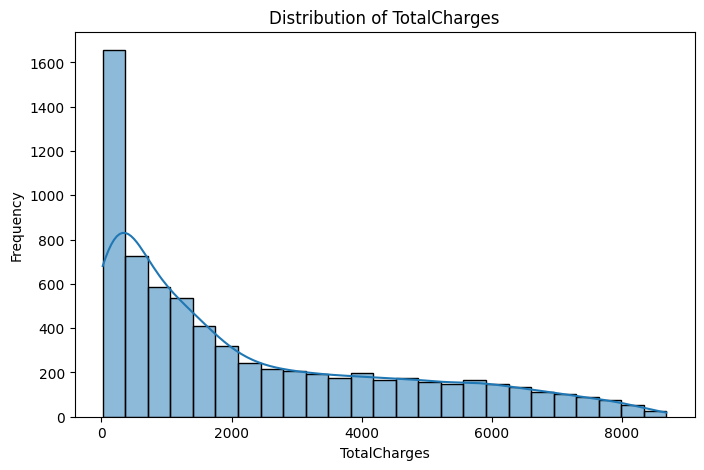

In [80]:


# Assuming numerical_features is your DataFrame containing numerical features
for column in numerical_features.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=numerical_features[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.ylabel('Frequency')
    plt.show()



we note that the  distributions of the
 data are skewed

## Handling Skwed Data

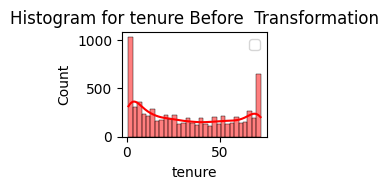

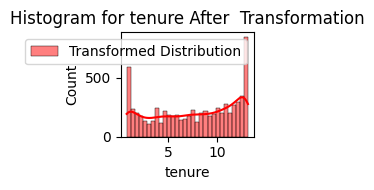

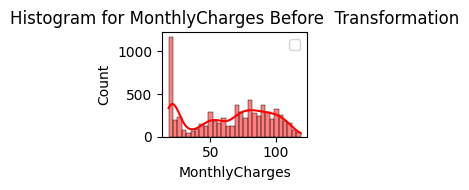

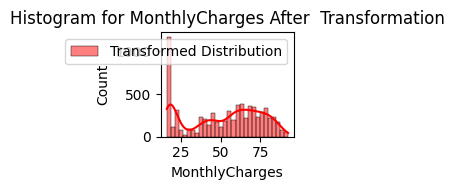

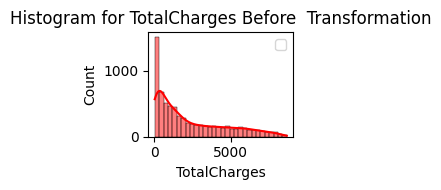

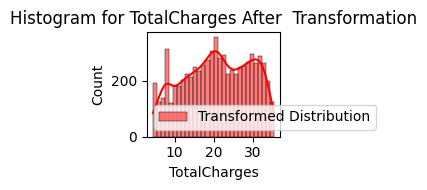

In [81]:

# Loop through each numerical feature
for feature in numerical_features:

      # Plot histograms before and after transformation
    plt.figure(figsize=(4, 2))


    # Plot histogram after transformation
    plt.subplot(1, 2, 2)
    sns.histplot(data[feature], bins=30, kde=True, color='red')
    plt.title(f'Histogram for {feature} Before  Transformation')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Apply transformation
    transformed_feature, lambda_value = yeojohnson(data[feature])
    data[feature] = yeojohnson(data[feature], lmbda=lambda_value)


    # Plot histograms before and after transformation
    plt.figure(figsize=(4, 2))


    # Plot histogram after transformation
    plt.subplot(1, 2, 2)
    sns.histplot( data[feature], bins=30, kde=True, color='red', label='Transformed Distribution')
    plt.title(f'Histogram for {feature} After  Transformation')
    plt.legend()

    plt.tight_layout()
    plt.show()

# EDA and Preprocessing For Categorical Features

In [82]:
#select the catgorical features only and drop target
categorical_features = data.select_dtypes(include=[object])

## Ensure From The Data Types

In [83]:
#Ensure from the count of catgorical features
cat_columns = len(categorical_features.columns)
print(f"Number of columns in categorical_features: {cat_columns}")

Number of columns in categorical_features: 16


In [84]:
head_categorical=categorical_features.head()

html_head_categorical = create_scrollable_table(head_categorical, 'head_categorical', 'Head of the categorical features')

# Display the HTML
display(HTML(html_head_categorical))

In [85]:
#the unique values of each numrical feature

def display_unique_values(dataframe):
    unique_values_html = ""
    for column in dataframe.columns:
        unique_values = dataframe[column].unique()
        unique_values_html += f"<h4>Unique values for {column}:</h4>"
        unique_values_html += "<div style='max-height: 200px; overflow-y: auto;'>"
        unique_values_html += "<ul>"
        for value in unique_values:
            unique_values_html += f"<li>{value}</li>"
        unique_values_html += "</ul>"
        unique_values_html += "</div>"

    display(HTML(unique_values_html))

# Call the function to display unique values
display_unique_values(categorical_features)

##  Summary statistics for categorical features

In [86]:

cat_summary_stats = categorical_features.describe().T
html_categorical = create_scrollable_table(cat_summary_stats, 'categorical_features', 'Summary statistics for categorical features')

display(HTML(html_categorical ))

## Chi_Squre Test

In [87]:


# Assuming df is your DataFrame with categorical features and target variable
# Replace 'TargetColumn' with the actual name of your target column
target_column = 'Churn'
significance_level = 0.05

# Create a list to store results
results = []

# Create a contingency table for each pair of categorical feature and target variable
for column in categorical_features:
    if column != target_column:
        contingency_table = pd.crosstab(categorical_features[column], data[target_column])
        chi2, p, _, _ = chi2_contingency(contingency_table)

        significance = "Significant" if p < significance_level else "Not Significant"

        results.append([column, chi2, p, significance])

# Create a DataFrame from the results
result_df = pd.DataFrame(results, columns=["Feature", "Chi2 Statistic", "P-value", "Significance"])

# Print the tabulated results
print('chi_squre Test Between The Target Varaible (churn) And the Categorical Features :')
print(tabulate(result_df, headers='keys', tablefmt='pretty', showindex=False))


chi_squre Test Between The Target Varaible (churn) And the Categorical Features :
+------------------+--------------------+-------------------------+-----------------+
|     Feature      |   Chi2 Statistic   |         P-value         |  Significance   |
+------------------+--------------------+-------------------------+-----------------+
|      gender      | 0.491236602618337  |   0.4833762023458479    | Not Significant |
|  SeniorCitizen   | 159.4792982375864  | 1.4703357738516273e-36  |   Significant   |
|     Partner      | 154.26693117310947 | 2.0248561714739414e-35  |   Significant   |
|    Dependents    | 183.99998732389344 |  6.48802519091279e-42   |   Significant   |
|   PhoneService   | 0.7766911304348848 |   0.37815502389537725   | Not Significant |
|  MultipleLines   | 12.303285849890518 |  0.002129979497390785   |   Significant   |
| InternetService  |  728.444400823442  | 6.611624411865297e-159  |   Significant   |
|  OnlineSecurity  | 843.4654315552659  | 6.97924910754270

we note that gender and phoneservice are not significant with the target variable  and we can remove them from the data

In [88]:
# Drop columns from the original DataFrame
data = data.drop(['gender', 'PhoneService'], axis=1)

# If 'categorical_features' is a DataFrame, drop columns from it as well
if 'categorical_features' in locals() or 'categorical_features' in globals():
    categorical_features = categorical_features.drop(['gender', 'PhoneService'], axis=1)


## Categorical Features Encoding

In [89]:
categorical_features_without_senior = [col for col in categorical_features if col != 'SeniorCitizen']

# Apply one-hot encoding excluding 'SeniorCitizen'
data_encoded = pd.get_dummies(data[categorical_features_without_senior])

# Replace the original categorical columns with the one-hot encoded columns
data = pd.concat([data.drop(columns=categorical_features_without_senior), data_encoded], axis=1)

#ensure
head = data.head()
# create_scrollable_table is defined somewhere in your code
html_head = create_scrollable_table(head, 'head', 'Head of the dataset')

# Display the HTML table to show all features
display(HTML(html_head))

# Feature engineering and selection

## Applying Filter Methods

### correlation analysis

In [90]:


# Assuming 'df' is your DataFrame with encoded features
encoded_features = data.drop(['Churn'], axis=1)

# Calculate the correlation matrix
correlation_matrix = encoded_features.corr()

# Set a threshold for high correlation (adjust as needed)
threshold = 0.9

# Extract pairs of highly correlated features
high_correlation_pairs = (correlation_matrix.abs() > threshold) & (correlation_matrix < 1)

# Create a DataFrame for the result
high_correlation_table = pd.DataFrame(columns=['Feature 1', 'Feature 2', 'Correlation'])

for i in range(len(high_correlation_pairs.columns)):
    for j in range(i + 1, len(high_correlation_pairs.columns)):
        if high_correlation_pairs.iloc[i, j]:
            feature_1 = high_correlation_pairs.columns[i]
            feature_2 = high_correlation_pairs.index[j]
            correlation = correlation_matrix.loc[feature_1, feature_2]
            high_correlation_table = high_correlation_table.append({'Feature 1': feature_1,
                                                                    'Feature 2': feature_2,
                                                                    'Correlation': correlation},
                                                                    ignore_index=True)

# # Display the result
# print(high_correlation_table)


# create_scrollable_table is defined somewhere in your code
html_high_correlation_table = create_scrollable_table(high_correlation_table, 'high_correlation_table', 'high_correlation_table')

# Display the HTML table to show all features
display(HTML(html_high_correlation_table))


<ipython-input-90-e0381e12fb71>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = encoded_features.corr()
<ipython-input-90-e0381e12fb71>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_correlation_table = high_correlation_table.append({'Feature 1': feature_1,
<ipython-input-90-e0381e12fb71>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_correlation_table = high_correlation_table.append({'Feature 1': feature_1,
<ipython-input-90-e0381e12fb71>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_correlation_table = hig

In [91]:
data.drop(['Partner_Yes', 'Dependents_Yes', 'PaperlessBilling_No','tenure'], axis=1, inplace=True)


- we will remove ['Partner_Yes', 'Dependents_Yes', 'PaperlessBilling_No','tenure'] from the data becuse they high correlated together
- we removed the non_significated features on step before

## Data Preparation

In [92]:
data.columns

Index(['SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'Partner_No', 'Dependents_No', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)'

### seprate the data

In [93]:
# Data Separation as X and Y
y= data['Churn']
x= data.drop('Churn',axis=1)

### handling the unbalanced data

In [94]:


# Assuming 'x' are your features and 'y' is the target variable
# Replace 'x' and 'y' with your actual feature and target variable

# Print the class distribution before undersampling
print("Class distribution before undersampling:")
print(y.value_counts())


# Set the desired number of samples for each class
desired_samples = 300  # Adjust this number based on your requirements

# Apply RandomUnderSampler for undersampling
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)  # or 'majority'

# Undersample the data
x_resampled, y_resampled = rus.fit_resample(x, y)

# Convert the resampled data back to a DataFrame (if necessary)
x_resampled = pd.DataFrame(x_resampled)
y_resampled = pd.Series(y_resampled)

# Print the class distribution after undersampling
print("\nClass distribution after undersampling:")
print(y_resampled.value_counts())


Class distribution before undersampling:
0    5153
1    1857
Name: Churn, dtype: int64

Class distribution after undersampling:
0    1857
1    1857
Name: Churn, dtype: int64


### split training set and test set

In [95]:

#split the data in training set and test set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

### scale the data

In [96]:


# Create the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform on training data
x_train = scaler.fit_transform(x_train)

# Transform on test data
x_test = scaler.transform(x_test)

# Assuming x_train and x_test are NumPy arrays
cols = list(range(x_train.shape[1]))
# Convert the standardized NumPy arrays back to DataFrames
x_train = pd.DataFrame(x_train, columns=cols)
x_test = pd.DataFrame(x_test, columns=cols)

In [97]:
print('Data:    ',data.shape)
print('----------------')
print('x train: ',x_train.shape)
print('y train: ',y_train.shape)
print('----------------')
print('x test:  ',x_test.shape)
print('y test:  ',y_test.shape)

Data:     (7010, 38)
----------------
x train:  (5608, 37)
y train:  (5608,)
----------------
x test:   (1402, 37)
y test:   (1402,)


# Classification Models

## Logistic Regreission Model

In [107]:


# Define Logistic Regression Model
lr_model = LogisticRegression()

# Set Up Parameter Grid
param_grid = {
    'penalty': ['l2',None],
    'C': (0.1, 0.0001, 0.6),
    'solver': ['lbfgs','sag','saga'],
    'max_iter': [100,50,10],
    'multi_class':['auto']
}

# Create GridSearchCV Object
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(x_train, y_train)

# Get Best Parameters and Model
best_params = grid_search.best_params_
best_lr_model = grid_search.best_estimator_

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)


#calculate_(f1_score)
# Evaluate the model on the test set and train test using the best parameters
best_lr_model = grid_search.best_estimator_
y_lr_pred_test = best_lr_model.predict(x_test)
y_lr_pred_train= best_lr_model.predict(x_train)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_lr_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)
f1_train = f1_score(y_train,y_lr_pred_train, average='weighted')
print("F1 Score on train Set:", f1_train)

#calculate_accurcy
# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_lr_pred_test)

# Evaluate on the training set
train_accuracy = accuracy_score(y_train,y_lr_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Classification Report
class_report_test = classification_report(y_test, y_lr_pred_test)

class_report_train = classification_report(y_train,y_lr_pred_train)

print("\nClassification Report_test set:")
print(class_report_test)


print("\nClassification Report_train set:")
print(class_report_train)




Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and

Best Parameters: {'C': 0.6, 'max_iter': 50, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
F1 Score on Test Set: 0.8025076155161822
F1 Score on train Set: 0.8030986518822233
Training Accuracy: 0.8104493580599144
Test Accuracy: 0.8088445078459344

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1030
           1       0.67      0.55      0.60       372

    accuracy                           0.81      1402
   macro avg       0.76      0.73      0.74      1402
weighted avg       0.80      0.81      0.80      1402


Classification Report_train set:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4123
           1       0.68      0.54      0.60      1485

    accuracy                           0.81      5608
   macro avg       0.76      0.72      0.74      5608
weighted avg       0.80      0.81      0.80      5608



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## SVM Model

In [108]:


# Define Support Vector Machine (SVM) Model
svm_model = SVC()

# Set Up Parameter Grid
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 0.0001, 10],
    'gamma': ['auto']
}

# Create GridSearchCV Object
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(x_train, y_train)

# Get Best Parameters and Model
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_

# Print the best parameters found by GridSearchCV
print("Best Parameters:", best_params)

# Evaluate the model on the test set and train set using the best parameters
y_svm_pred_test = best_svm_model.predict(x_test)
y_svm_pred_train = best_svm_model.predict(x_train)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_svm_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)

f1_train = f1_score(y_train, y_svm_pred_train, average='weighted')
print("F1 Score on Train Set:", f1_train)

# Evaluate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_svm_pred_test)

# Evaluate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_svm_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Classification Report
class_report_test = classification_report(y_test, y_svm_pred_test)

class_report_train = classification_report(y_train,y_svm_pred_train)

print("\nClassification Report_test set:")
print(class_report_test)


print("\nClassification Report_train set:")
print(class_report_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
F1 Score on Test Set: 0.801602477114632
F1 Score on Train Set: 0.8006265322684758
Training Accuracy: 0.8100927246790299
Test Accuracy: 0.8088445078459344

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.85      0.91      0.87      1030
           1       0.67      0.54      0.60       372

    accuracy                           0.81      1402
   macro avg       0.76      0.72      0.74      1402
weighted avg       0.80      0.81      0.80      1402


Classification Report_train set:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      4123
           1       0.69      0.52      0.59      1485

    accuracy                           0.81      5608
   macro avg       0.76      0.72      0.73      5608
weighted avg       0.80      0.81      0.80      5608



## Naive Model

In [109]:


# Assuming x_train, x_test, y_train, y_test are your features and target variable
# Replace x_train, x_test, y_train, y_test with your actual feature and target variable

# Set up parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]  # Adjust the values based on your needs
}

# Create Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Create GridSearchCV object
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_nb_model = grid_search.best_estimator_

# Make predictions
y_nb_pred_train = best_nb_model.predict(x_train)
y_nb_pred_test = best_nb_model.predict(x_test)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", best_params)

# Evaluate the model on the test set and train set using the best parameters
y_nb_pred_test = best_nb_model.predict(x_test)
y_nb_pred_train = best_nb_model.predict(x_train)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_nb_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)

f1_train = f1_score(y_train, y_nb_pred_train, average='weighted')
print("F1 Score on Train Set:", f1_train)

# Evaluate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_nb_pred_test)

# Evaluate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_nb_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Classification Report
class_report_test = classification_report(y_test, y_nb_pred_test)

class_report_train = classification_report(y_train,y_nb_pred_train)

print("\nClassification Report_test set:")
print(class_report_test)


print("\nClassification Report_train set:")
print(class_report_train)



Best Parameters: {'alpha': 0.1}
F1 Score on Test Set: 0.7038077972268566
F1 Score on Train Set: 0.7371230437021014
Training Accuracy: 0.7211126961483595
Test Accuracy: 0.6854493580599144

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.90      0.64      0.75      1030
           1       0.45      0.80      0.57       372

    accuracy                           0.69      1402
   macro avg       0.67      0.72      0.66      1402
weighted avg       0.78      0.69      0.70      1402


Classification Report_train set:
              precision    recall  f1-score   support

           0       0.91      0.69      0.78      4123
           1       0.48      0.82      0.61      1485

    accuracy                           0.72      5608
   macro avg       0.70      0.75      0.70      5608
weighted avg       0.80      0.72      0.74      5608



## KNN Model

In [102]:


# Define the KNN model
knn_model = KNeighborsClassifier()

# fit the model to the training set
knn_model.fit(x_train, y_train)

# Define the parameter grid
param_grid ={'leaf_size': range(1,20),
        'p': [1,2],
        'n_neighbors': range(1,21,3)}

# Use F1 score as the scoring metric for GridSearchCV
f1_scorer = make_scorer(f1_score, average='weighted')

# Perform GridSearchCV
grid_search = GridSearchCV(knn_model, param_grid, scoring=f1_scorer, cv=5)
grid_search.fit(x_train, y_train)  # Use X_train and y_train

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring=f1_scorer)
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# Evaluate the model on the test set and train set using the best parameters
best_knn_model = grid_search.best_estimator_
y_knn_pred_test = best_knn_model.predict(x_test)
y_knn_pred_train = best_knn_model.predict(x_train)



# Calculate F1 score on the test set and train set
f1_test = f1_score(y_test, y_knn_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)
f1_train = f1_score(y_train, y_knn_pred_train, average='weighted')
print("F1 Score on Train Set:", f1_train)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_knn_pred_test)
train_accuracy = accuracy_score(y_train, y_knn_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


# Classification Report
class_report_test = classification_report(y_test, y_knn_pred_test)

class_report_train = classification_report(y_train,y_knn_pred_train)

print("\nClassification Report_test set:")
print(class_report_test)


print("\nClassification Report_train set:")
print(class_report_train)

Best Parameters: {'leaf_size': 1, 'n_neighbors': 13, 'p': 2}
Cross-Validation Scores: [0.77386965 0.77902486 0.78152194 0.77831283 0.77610925]
Average Cross-Validation Score: 0.7777677046562287
F1 Score on Test Set: 0.7635982477434492
F1 Score on Train Set: 0.8031253945520134
Training Accuracy: 0.8063480741797432
Test Accuracy: 0.7631954350927247

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1030
           1       0.55      0.56      0.56       372

    accuracy                           0.76      1402
   macro avg       0.70      0.70      0.70      1402
weighted avg       0.76      0.76      0.76      1402


Classification Report_train set:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      4123
           1       0.65      0.59      0.62      1485

    accuracy                           0.81      5608
   macro avg       0.75      0.74      

## DecisionTree Model

In [103]:


# Define the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 5, 30, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [10, 5]
}

# Use F1 score as the scoring metric for GridSearchCV
f1_scorer = make_scorer(f1_score, average='weighted')

# Perform GridSearchCV
grid_search = GridSearchCV(dt_model, param_grid, scoring=f1_scorer, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring=f1_scorer)
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

#calculate_(f1_score)
# Evaluate the model on the test set and train test using the best parameters
best_dt_model = grid_search.best_estimator_
y_dt_pred_test = best_dt_model.predict(x_test)
y_dt_pred_train= best_dt_model.predict(x_train)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_dt_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)
f1_train = f1_score(y_train, y_dt_pred_train, average='weighted')
print("F1 Score on train Set:", f1_train)

#calculate_accurcy
# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_dt_pred_test)

# Evaluate on the training set
train_accuracy = accuracy_score(y_train, y_dt_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Classification Report
class_report_test = classification_report(y_test, y_dt_pred_test)

class_report_train = classification_report(y_train,y_dt_pred_train)

print("\nClassification Report_test set:")
print(class_report_test)


print("\nClassification Report_train set:")
print(class_report_train)

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
Cross-Validation Scores: [0.76746954 0.7794368  0.78312638 0.79422271 0.78062077]
Average Cross-Validation Score: 0.7809752410347863
F1 Score on Test Set: 0.7956506178525516
F1 Score on train Set: 0.7986308406269115
Training Accuracy: 0.8027817403708987
Test Accuracy: 0.7981455064194009

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1030
           1       0.63      0.58      0.61       372

    accuracy                           0.80      1402
   macro avg       0.74      0.73      0.73      1402
weighted avg       0.79      0.80      0.80      1402


Classification Report_train set:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4123
           1       0.64      0.57      0.60      1485

    accuracy                           0.80      

## RandomForest

In [104]:


# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [250,270],
    'max_depth': [10, 5, 2],
    'min_samples_split': [10,7],
    'min_samples_leaf': [4, 2],
 }

# Use F1 score as the scoring metric for GridSearchCV
f1_scorer = make_scorer(f1_score, average='weighted')

# Perform GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, scoring=f1_scorer, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring=f1_scorer)
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# #calculate_(f1_score)
# # Evaluate the model on the test set and train test using the best parameters
best_rf_model = grid_search.best_estimator_

y_rf_pred_test = best_rf_model.predict(x_test)
y_rf_pred_train= best_rf_model.predict(x_train)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_rf_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)
f1_train = f1_score(y_train, y_rf_pred_train, average='weighted')
print("F1 Score on train Set:", f1_train)

#calculate_accurcy
# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_rf_pred_test)

# Evaluate on the training set
train_accuracy = accuracy_score(y_train, y_rf_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Classification Report
class_report_test = classification_report(y_test, y_rf_pred_test)

class_report_train = classification_report(y_train,y_rf_pred_train)

print("\nClassification Report_test set:")
print(class_report_test)


print("\nClassification Report_train set:")
print(class_report_train)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 250}
Cross-Validation Scores: [0.78985087 0.78706003 0.78812366 0.80288608 0.78890334]
Average Cross-Validation Score: 0.7913647961676065
F1 Score on Test Set: 0.79859135064993
F1 Score on train Set: 0.8504829204911559
Training Accuracy: 0.854493580599144
Test Accuracy: 0.8031383737517832

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1030
           1       0.65      0.56      0.60       372

    accuracy                           0.80      1402
   macro avg       0.75      0.73      0.74      1402
weighted avg       0.80      0.80      0.80      1402


Classification Report_train set:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4123
           1       0.77      0.65      0.70      1485

    accuracy                           0.85      5608


##GradientBoosting Model

In [105]:


# Define the Random Forest model
gb_model = GradientBoostingClassifier()

# Define the parameter grid for GridSearchCV
# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.6,],
    'n_estimators': [250, 150],
    'subsample': [ 0.8, 1.0],
    'min_samples_split': [ 10, 7],
    'min_samples_leaf': [ 2, 4],
    'max_depth': [ 5, 10],

}

# Use F1 score as the scoring metric for GridSearchCV
f1_scorer = make_scorer(f1_score, average='weighted')

# Perform GridSearchCV
grid_search = GridSearchCV(gb_model, param_grid, scoring=f1_scorer, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring=f1_scorer)
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# #calculate_(f1_score)
# # Evaluate the model on the test set and train test using the best parameters
best_gb_model = grid_search.best_estimator_

y_gb_pred_test = best_gb_model.predict(x_test)
y_gb_pred_train= best_gb_model.predict(x_train)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_gb_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)
f1_train = f1_score(y_train, y_gb_pred_train, average='weighted')
print("F1 Score on train Set:", f1_train)

#calculate_accurcy
# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_gb_pred_test)

# Evaluate on the training set
train_accuracy = accuracy_score(y_train, y_gb_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Classification Report
class_report_test = classification_report(y_test, y_gb_pred_test)

class_report_train = classification_report(y_train,y_gb_pred_train)

print("\nClassification Report_test set:")
print(class_report_test)


print("\nClassification Report_train set:")
print(class_report_train)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250, 'subsample': 0.8}
Cross-Validation Scores: [0.79031194 0.79776751 0.78427945 0.78990335 0.78325861]
Average Cross-Validation Score: 0.7891041693036746
F1 Score on Test Set: 0.7992648860213631
F1 Score on train Set: 0.8197778261564809
Training Accuracy: 0.828281027104137
Test Accuracy: 0.8067047075606276

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1030
           1       0.67      0.53      0.59       372

    accuracy                           0.81      1402
   macro avg       0.76      0.72      0.73      1402
weighted avg       0.80      0.81      0.80      1402


Classification Report_train set:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4123
           1       0.73      0.55      0.63      1485

    accurac

## XGBoosting Model

In [116]:

# Define the Random Forest model
xg_model =  XGBClassifier()

# Define the parameter grid for GridSearchCV
# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [250, 50],
    'subsample': [ 0.01, 1.0],
    'min_child_weight' : [1,2],
    'colsample_bytree' :[ 0.8, 0.1],
    'max_depth': [ 5, 2],

}

# Use F1 score as the scoring metric for GridSearchCV
f1_scorer = make_scorer(f1_score, average='weighted')

# Perform GridSearchCV
grid_search = GridSearchCV(xg_model, param_grid, scoring=f1_scorer, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring=f1_scorer)
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# #calculate_(f1_score)
# # Evaluate the model on the test set and train test using the best parameters
best_xg_model = grid_search.best_estimator_

y_xg_pred_test = best_xg_model.predict(x_test)
y_xg_pred_train= best_xg_model.predict(x_train)

# Calculate F1 score on the test set
f1_test = f1_score(y_test, y_xg_pred_test, average='weighted')
print("F1 Score on Test Set:", f1_test)
f1_train = f1_score(y_train, y_xg_pred_train, average='weighted')
print("F1 Score on train Set:", f1_train)

#calculate_accurcy
# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_xg_pred_test)

# Evaluate on the training set
train_accuracy = accuracy_score(y_train, y_xg_pred_train)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Classification Report
class_report_test = classification_report(y_test, y_xg_pred_test)

class_report_train = classification_report(y_train,y_xg_pred_train)

print("\nClassification Report_test set:")
print(class_report_test)


print("\nClassification Report_train set:")
print(class_report_train)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 250, 'subsample': 1.0}
Cross-Validation Scores: [0.7958652  0.79411765 0.79651791 0.81480471 0.7938606 ]
Average Cross-Validation Score: 0.7990332148378733
F1 Score on Test Set: 0.7942288265402628
F1 Score on train Set: 0.811359096246382
Training Accuracy: 0.8182952924393724
Test Accuracy: 0.7981455064194009

Classification Report_test set:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1030
           1       0.63      0.56      0.60       372

    accuracy                           0.80      1402
   macro avg       0.74      0.72      0.73      1402
weighted avg       0.79      0.80      0.79      1402


Classification Report_train set:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4123
           1       0.70      0.56      0.62      1485

    accuracy

# Choose The Best Model

In [146]:


# Provided results
results = {
    'Model': ['Logistic Regression', 'SVM', 'Naive Model', 'KNN', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'XGBoosting'],
    'F1 Score (Test)': [0.8025076155161822, 0.801602477114632, 0.7038077972268566, 0.7635982477434492, 0.7956506178525516, 0.79859135064993, 0.7992648860213631, 0.7942288265402628],
    'F1 Score (Train)': [0.8030986518822233, 0.8006265322684758, 0.7371230437021014, 0.8031253945520134, 0.7986308406269115, 0.8504829204911559, 0.8197778261564809, 0.811359096246382],
    'Training Accuracy': [0.8104493580599144, 0.8100927246790299, 0.7211126961483595, 0.8063480741797432, 0.8027817403708987, 0.854493580599144, 0.828281027104137, 0.8182952924393724],
    'Test Accuracy': [0.8088445078459344, 0.8088445078459344, 0.6854493580599144, 0.7631954350927247, 0.7981455064194009, 0.8031383737517832, 0.8067047075606276, 0.7981455064194009]
}

# Create a DataFrame
results_df = pd.DataFrame(results)

# Add columns for differences
results_df['F1 Score Diff'] = results_df['F1 Score (Train)'] - results_df['F1 Score (Test)']
results_df['Accuracy Diff'] = results_df['Training Accuracy'] - results_df['Test Accuracy']

# Sort based on the highest F1 Score (Test)
results_df_sorted = results_df.sort_values(by='F1 Score (Test)', ascending=False)



# Sort based on the lowest F1 Score Diff
results_df_sorted = results_df.sort_values(by='F1 Score Diff',)


html_results_df_sorted = create_scrollable_table(results_df_sorted, 'results_df_sorted', 'Models Sorted By The Best')

# Display the HTML
display(HTML(html_results_df_sorted))


from this outputs, I will choose the SVM model as the best model to predict this data